In [3]:
import sys; sys.path.append("..")

import numpy as np
import logging

from numpy import pi
from dedalus.extras import flow_tools

from dedaLES import dedaLES as dedaLES
from dedalus.extras.plot_tools import plot_bot_3d

import time

startt = time.time()

# from dedaLES import mpiprint

logger = logging.getLogger(__name__)

def log_magnitude(xmesh, ymesh, data):
    '''
    Log magnitude function for scaling a magnitude for plotting
    complex valueds scalar fields
    '''
    return xmesh, ymesh, np.log10(np.abs(data))

# Parameters
nx = ny = nz = 32
Lx = Ly = Lz = 2*pi

# Homoegneous Navier-Stokes equations with Constant Smagorinsky LES closure
closure = dedaLES.AnisotropicMinimumDissipation()
model = dedaLES.NavierStokesTriplyPeriodicFlow(nx=nx, ny=ny, nz=nz, Lx=Lx, Ly=Ly, Lz=Lz,
                                               ν=1.0, closure=closure)
model.build_solver()

# Random initial condition. Re_k = u k / ν => u ~ ν * Re_k / k
Re = 1000.0 # Re at grid scale
u0 = Re/nx
model.u['g'] = u0 * dedaLES.random_noise(model.domain, seed=23)
model.v['g'] = u0 * dedaLES.random_noise(model.domain, seed=42)

model.u['g'] = model.u['g'] - np.mean(model.u['g'])
model.v['g'] = model.v['g'] - np.mean(model.v['g'])

# Diagnose w from continuity
ux = model.domain.new_field()
vy = model.domain.new_field()
wz = model.domain.new_field()
model.u.differentiate('x', out=ux)
model.v.differentiate('y', out=vy)
model.w.differentiate('z', out=wz)

wz['g'] = - ux['g'] - vy['g']
wz.integrate('z', out=model.w)

# Plot energy spectra...

# Some logging things (that we ignore)
# cadence = 10
# flow = flow_tools.GlobalFlowProperty(model.solver, cadence=cadence)
# flow.add_property("sqrt(u*u + v*v + w*w) / ν", name='Re')
# def average_Re(model): return flow.volume_average('Re')
# def max_Re(model): return flow.max('Re')
# model.add_log_tasks(avg_Re=average_Re, max_Re=max_Re)

# Prepare to run the simulation
max_u = np.max(model.u['g'])
dt = 0.1 * 2*pi/(max_u*nx) # grid-scale turbulence time-scale = 1/(u*k)
model.stop_at(sim_time=np.inf, wall_time=np.inf, iteration=100)

print('Elapsed time: ' + str((time.time() - startt)))

2019-02-18 10:34:37,544 pencil 0/1 INFO :: Building pencil matrix 1/496 (~0%) Elapsed: 0s, Remaining: 6s, Rate: 8.1e+01/s
2019-02-18 10:34:38,162 pencil 0/1 INFO :: Building pencil matrix 50/496 (~10%) Elapsed: 1s, Remaining: 6s, Rate: 7.9e+01/s
2019-02-18 10:34:38,791 pencil 0/1 INFO :: Building pencil matrix 100/496 (~20%) Elapsed: 1s, Remaining: 5s, Rate: 7.9e+01/s
2019-02-18 10:34:39,398 pencil 0/1 INFO :: Building pencil matrix 150/496 (~30%) Elapsed: 2s, Remaining: 4s, Rate: 8.0e+01/s
2019-02-18 10:34:40,020 pencil 0/1 INFO :: Building pencil matrix 200/496 (~40%) Elapsed: 2s, Remaining: 4s, Rate: 8.0e+01/s
2019-02-18 10:34:40,644 pencil 0/1 INFO :: Building pencil matrix 250/496 (~50%) Elapsed: 3s, Remaining: 3s, Rate: 8.0e+01/s
2019-02-18 10:34:41,253 pencil 0/1 INFO :: Building pencil matrix 300/496 (~60%) Elapsed: 4s, Remaining: 2s, Rate: 8.1e+01/s
2019-02-18 10:34:41,869 pencil 0/1 INFO :: Building pencil matrix 350/496 (~71%) Elapsed: 4s, Remaining: 2s, Rate: 8.1e+01/s
2019

2019-02-18 10:35:43,430 solvers 0/1 INFO :: Stop iteration reached.
Elapsed time: 53.40231108665466


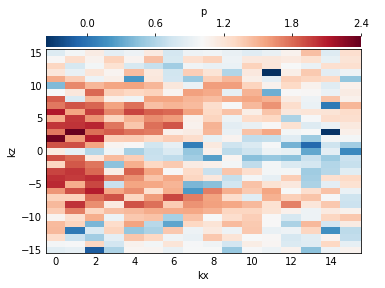

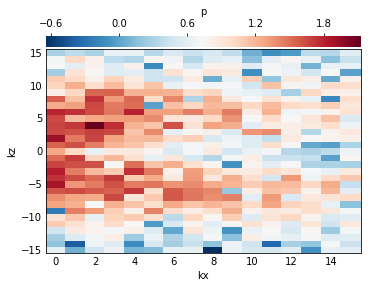

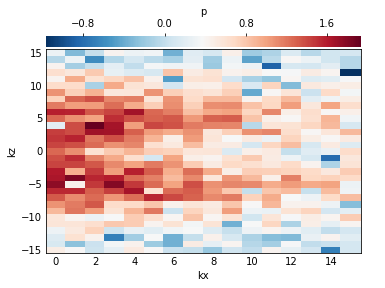

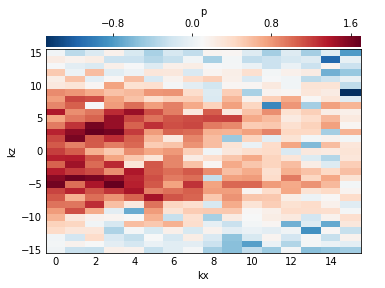

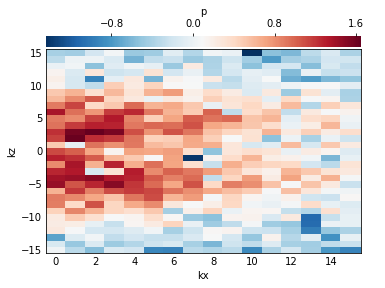

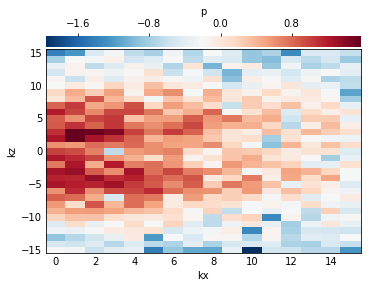

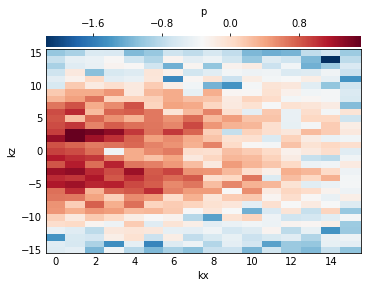

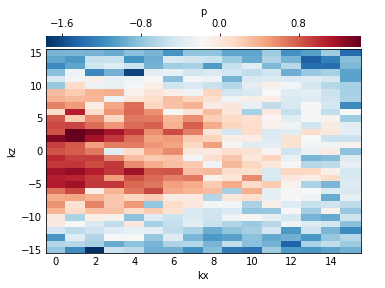

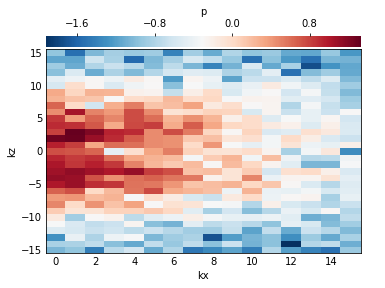

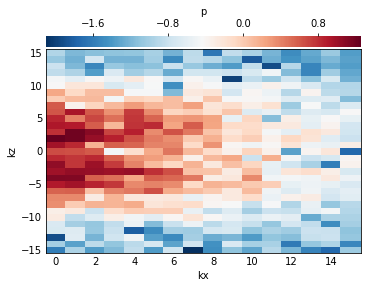

In [4]:
startt = time.time()

# Run the simulation, plot the pressure field occasionally
while model.solver.ok:
    model.solver.step(dt)
    if model.solver.iteration % 10 == 0:
        plot_bot_3d(model.solver.state['p'], 1, 1, func=log_magnitude);
        
print('Elapsed time: ' + str((time.time() - startt)))